
# Attribution 

When inspecting the impact of experiments it is very useful to be able to analyze which changed input causes the 
impact. Modelflow has some tools to automate this process and to visualize the impact. This chapter gives an introduction to the concept 'attribution' and demonstrates how Modelflow's built-in functionalities help you explore and understand your results and which variables drive the change. 


## Prepare a model and dataframe 
This class incorporates most of the methods used to manage a model. 

In [31]:
# Modules from Modelflow 
from modelclass import model 

# optional functionalities 
model.widescreen()
model.scroll_off()

# Output compatabiltity with LaTeX (is this true?)
latex=True

In [32]:
 %load_ext autoreload
 %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load a pre-existing model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions. 
The next cell:
 - Loads model and simulates to establish a baseline
 - Creates a dataframe with a tax rate of 29 USD/Ton for carbon emission for 3 sectors
 - Simulates the new experiment 
 
 You can find more on this experiment [here](../update/create_experiment.ipynb)

In [33]:
mpak,baseline = model.modelload('../../models/pak.pcim',alfa=0.7,run=1,keep='Business as Usual')
alternative  =  baseline.upd("<2020 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 29")
result = mpak(alternative,2020,2100,keep='Carbon tax nominal 29') # simulates the model 

(attribution)=
## Attribution 

Experience shows that it is useful to be able to explain the difference between the result from two runs.
 - The first level of understanding the difference is to look at selected formulas and find out, how much each input variables accounts for. 
 - The second level of understanding the difference is to look at the attribution of the 
exogenous variables to the results of the model.  

If we have:

$y = f(a,b)$

and we have two solutions where the variables differs by $\Delta y, \Delta a, \Delta b$

How much of $\Delta y$ can be explained by $\Delta a$ and $\Delta b$ ?

Analytical the attributions $\Omega a$ and $\Omega b$ can  be calculated like this: 

$\Delta y = \underbrace{\Delta a \dfrac{\partial {f}}{\partial{a}}(a,b)}_{\Omega a} + 
\underbrace{\Delta b \dfrac{\partial {f}}{\partial{b}}(a,b)}_{\Omega b}+Residual$

ModelFlow will do a numerical approximation of $\Omega a$ and $\Omega b$. This is done by looking at the two runs of the model:

\begin{eqnarray}  
y_0&=&f(a_{0},b_{0}) \\
y_1&=&f(a_0+\Delta a,b_{0}+ \Delta b)
\end{eqnarray}

So $\Omega a$ and $\Omega b$ can be determined:

\begin{eqnarray}  
\Omega f_a&=&f(a_1,b_1 )-f(a_1-\Delta a,b_1) \\
\Omega f_b&=&f(a_1,b_1 )-f(a_1,b_1-\Delta  b)
\end{eqnarray}



And: 

\begin{eqnarray}
residual = \Omega f_a + \Omega f_b -(y_1 - y_0) 
\end{eqnarray}
If the model is fairly linear, the residual will be small. 



## Which function: Model attribution or  single equation attribution?

To recap. Above we just used the term $f$ for the function. $f$ can actually be two different functions. 
 - The complete model<br>In this case the $\Delta a$,$\Delta b$ ... can be different exogenous variables. 
 - A single equation <br>In this case the $\Delta a$,$\Delta b$ ... can be all the current and lagged variables on the right hand side of the = in the equation  
 
 Examples will be given below. 

## Which output?

Let's pretend we only have two variables $a$ and $b$: 

- Absolute levels:  $\Omega a$ and $\Omega b$ ...
- Relative impact in percent:  $\cfrac{100*\Omega a}{\Omega a + \Omega b}$  $\cfrac{100*\Omega b}{\Omega a + \Omega b}$
- impact on the growth rate of  $a$ and $b$

## Which input?
What exactly is $\Delta a$ and $\Delta b$? There are two possibilities: 

1. The difference between the two scenarios in .basedf and .lastdf
2. The time $\Delta$ in variable $\Delta a = a_t - a_{t-1}$ and $\Delta b = b_t - b_{t-1}$ taken from .lastdf



### .totdif() Makes an instance of a  model attribution class
.totdif() returns a class instance of the totdif class. The totdif class contains a number of 
methods and properties which can slice and dice attribution at the model level.<br> Without any parameters it 
takes all changed exogenous variables and finds the attribution from each of these.

To do this it simulates the model a number of times. So If many exogenous differ this can take some time. 

In [34]:
totdekomp = mpak.totdif()

Total dekomp took       :         4.513 Seconds


### .explain_all will visualize the results

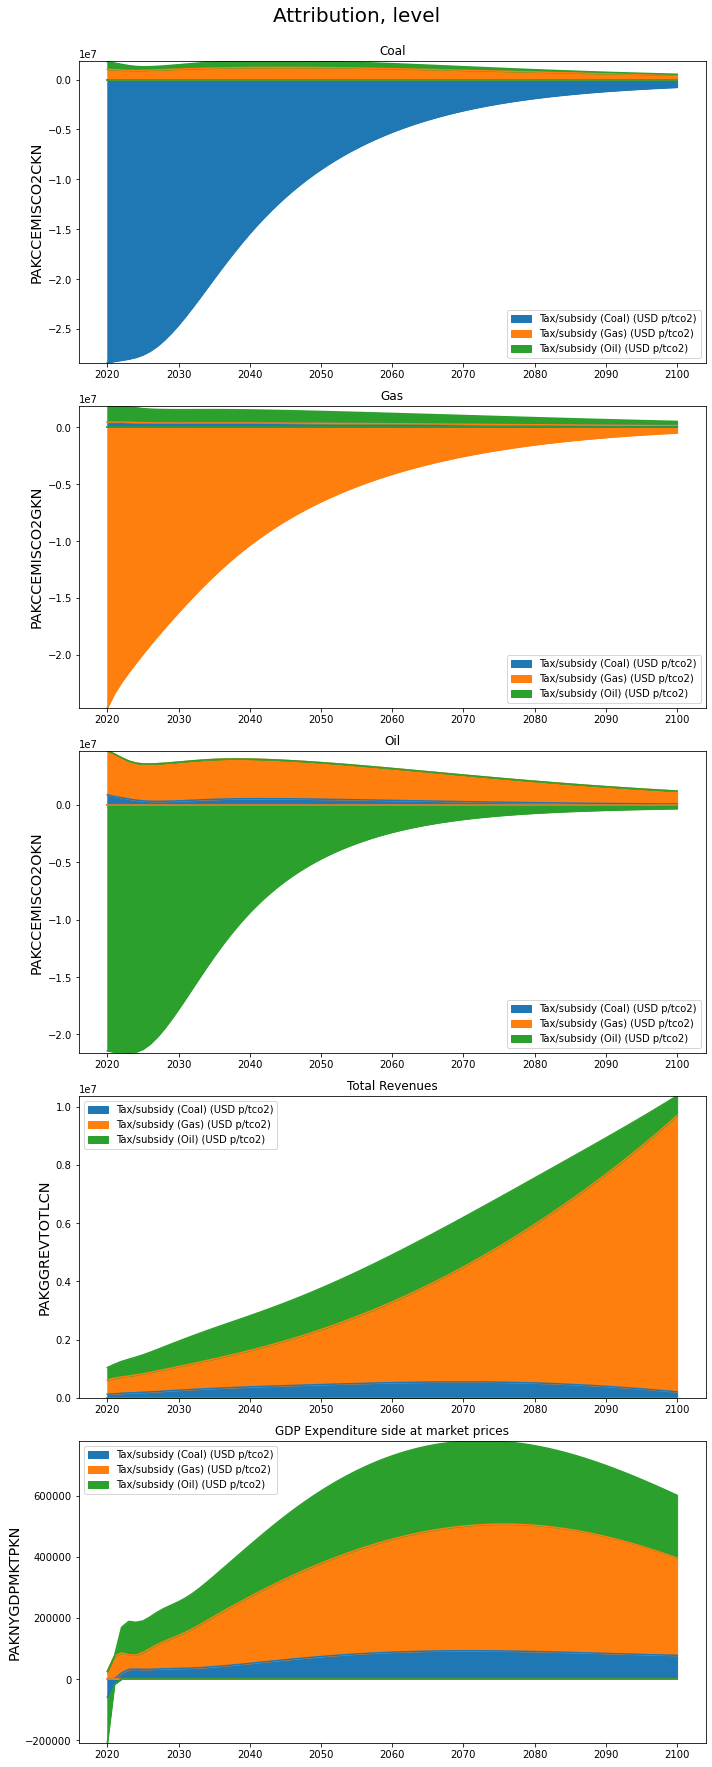

In [52]:
showvar = 'PAKNYGDPMKTPKN PAKCCEMISCO2CKN PAKCCEMISCO2OKN PAKCCEMISCO2GKN PAKGGREVTOTLCN'
totdekomp.explain_all(showvar,kind='area',stacked=True,top=0.95);    


### Or we can use interactive widgets
This allows the user to select the specific variable of interest and what to display: 


:::{note}
If this is read in a manual the widget is not live. 

In a notebook the selection widgets are live. 
:::


In [53]:
display(mpak.get_att_gui(var='PAKGGREVTOTLCN',ysize=7))

interactive(children=(Dropdown(description='Variable', index=108, options=('CHNEXR05', 'CHNPCEXN05', 'DEUEXR05…

None

When the results are displayed, they can be filtered, sliced and diced in a number of ways. 

### More advanced model attribution

For some  models (like the EBA bank stress test model) the number of changed exogenous variable can be large. Using a dictionary to contain the experiments allows us to create experiments where all variable for each country are analyzed, or each macro variable for all countries are analyzed. 

Also it is possible to use aggregated sums - useful for looking at impact on PD's. Or just the last time period - useful for looking at CET1 ratios. 

If there are many experiments, data can be filtered in order to look only at the variables with an impact above a certain threshold. 

The is also the possibility to anonymize the row and column names and to randomize
the order of rows and/or columns - useful for bank names. 

### Formula attribution
Attribution analysis on the formula level is performed by the method **.dekomp**. 

This method utilizes that two attributes .basedf and .lastdf containing the first and the last run are contained in the model instance. Also all the formulas are contained in the instance. Therefore a model, just with one formula - is created. Then experiments mentioned above is run for each period and each right hand side variable. 

### Single equation attribution output

In [37]:
with mpak.set_smpl(2020,2025):
    mpak['PAKCCEMISCO2TKN'].dekomp()


Formula        : FRML  <> PAKCCEMISCO2TKN = PAKCCEMISCO2CKN+PAKCCEMISCO2OKN+PAKCCEMISCO2GKN $ 

                            2020             2021             2022             2023             2024             2025
Variable    lag                                                                                                      
Base        0   216055772.843344 222601656.910145 230049529.327095 238103197.327412 246127123.544701 253659456.655154
Alternative 0   153705842.114083 160634232.900568 168319944.419260 176432099.882985 184790572.983322 193170251.993564
Difference  0   -62349930.729261 -61967424.009577 -61729584.907835 -61671097.444426 -61336550.561379 -60489204.661590
Percent     0         -28.858257       -27.837809       -26.833172       -25.900995       -24.920679       -23.846619

 Contributions to differende for  PAKCCEMISCO2TKN
                                2020             2021             2022             2023             2024             2025
Variable        lag   

<span style='color:Blue'> ORIGINAL </span>
### Show a chart with the attribution can be more useful

### Single equation attribution chart 

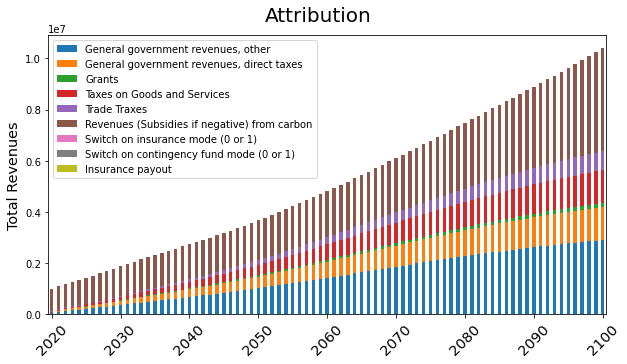

In [38]:
mpak.dekomp_plot('PAKGGREVTOTLCN',pct=0);

### Chart in pct of the total 

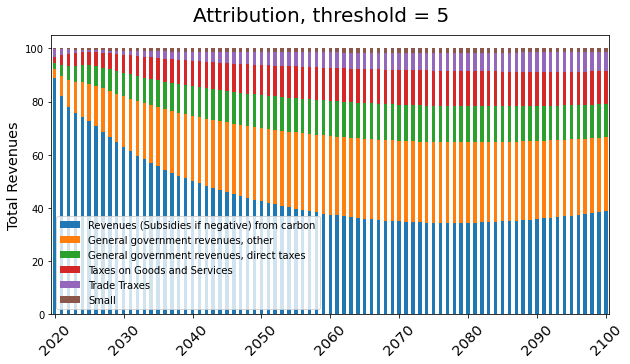

In [39]:
mpak.dekomp_plot('PAKGGREVTOTLCN',rename=1,threshold=5);

### Chart for one year 
Now GDP

<span style='color:Blue'> ORIGINAL </span>
### The Attributions can be sorted

### Sorting of attribution

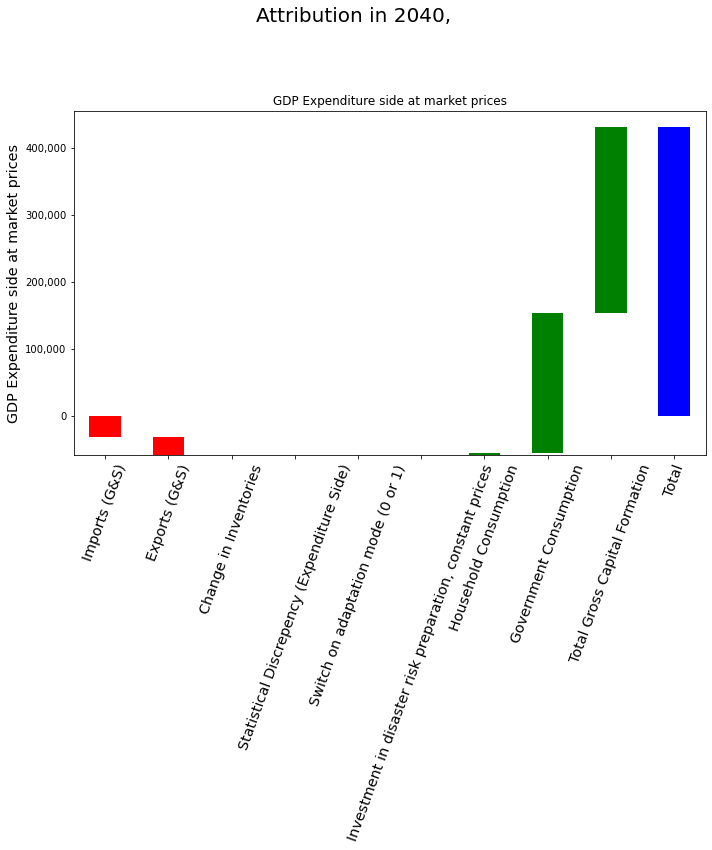

In [40]:
mpak.dekomp_plot_per('PAKNYGDPMKTPKN',per=2040,pct=0,rename=1,sort=1,ysize=12);

### Truncate attribution
Some equations have a lot of small contributions. These can be aggregated through the ```threshold=<some number>``` parameter. 
variables for which all contributions are below the threshold will be lumped together in the **small** bin. Like below

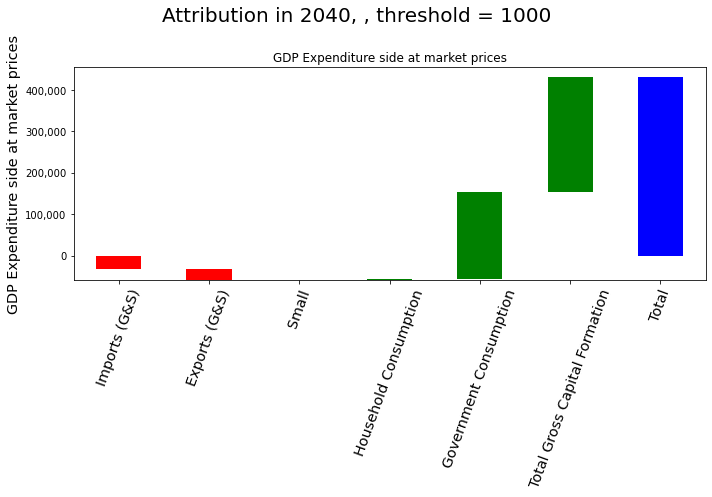

In [41]:
mpak.dekomp_plot_per('PAKNYGDPMKTPKN',per=2040,pct=0,rename=1,sort=1,threshold =1000,ysize=7);

### Attribution when comparing time frames 
In this case we seek to find out which variables explains the development from year to year. This is done only for the .lastdf dateframe. 

In [42]:
with mpak.set_smpl(2020,2024):
    mpak['PAKCCEMISCO2TKN'].dekomp(time_att=True)


Formula        : FRML  <> PAKCCEMISCO2TKN = PAKCCEMISCO2CKN+PAKCCEMISCO2OKN+PAKCCEMISCO2GKN $ 

                           2020             2021             2022             2023             2024
Variable   lag                                                                                     
t-1        0   209678812.348658 153705842.114083 160634232.900568 168319944.419260 176432099.882985
t          0   153705842.114083 160634232.900568 168319944.419260 176432099.882985 184790572.983322
Difference 0   -55972970.234575   6928390.786484   7685711.518692   8112155.463725   8358473.100337
Percent    0         -26.694624         4.507565         4.784604         4.819486         4.737501

 Contributions to differende for  PAKCCEMISCO2TKN
                                2020           2021           2022           2023           2024
Variable        lag                                                                             
PAKCCEMISCO2CKN 0   -22802127.557216 1646018.136919 178465

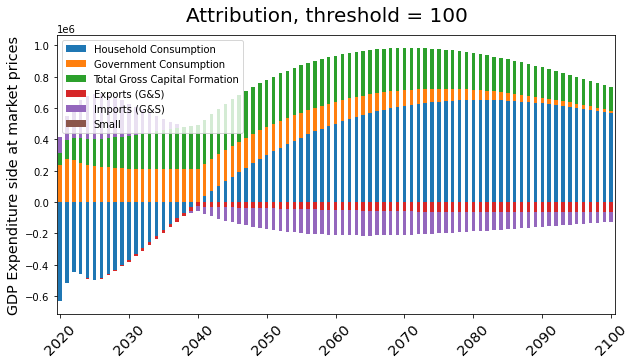

In [43]:
mpak.dekomp_plot('PAKNYGDPMKTPKN',pct=0,rename=1,sort=1,threshold =100,time_att = True);

### Visualizing attribution in dependency graphs
When drawing the logical graph of the model attribution will be used. This enables a visual impression of which 
variables matters. 

::: {note}
If png == 0 the graph below will be rendered in SVG format. This enables tooltips with additional information when the mouse hovers 
over an edge or an node. 

Unfortunately svg can't be displayed in the manual, so png has to be True for the manual. In a live jupyter notebook set latex=0. This will 
enable svg format. 
:::

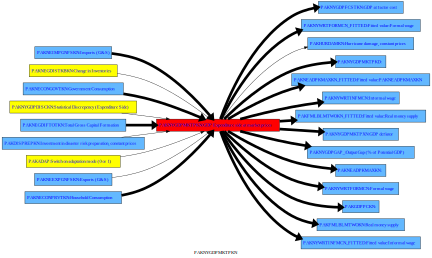

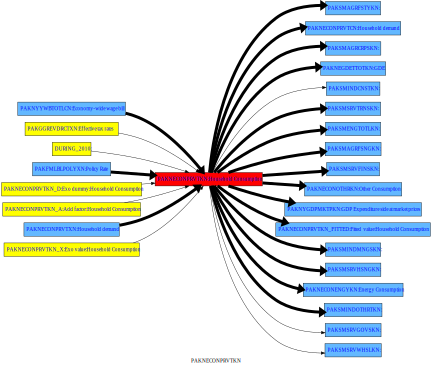

In [56]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].draw(up=1,down=1,png=latex)  # diagram all direct dependencies 